## MODELING

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

#### Data reading

In [2]:
df = pd.read_csv('datasets/salary_data_cleaned.csv', index_col=0)
pd.set_option('display.max_columns', None)
df.head()

,Rating,job_simpl,avg_salary,num_competitors,job_state,ownership,size,company_age,python,scala,tensorflow,aws,sql,spark,excel,phd,len_description
0,3.8,data scientist,53.0,0,NM,private,1 to 1000 employees,50.0,1,0,0,0,0,0,1,1,2536
1,3.4,data scientist,63.0,0,MD,other,5000+ employees,39.0,1,0,0,0,0,0,0,0,4783
2,4.8,data scientist,80.0,0,FL,private,1 to 1000 employees,13.0,1,0,0,0,1,1,1,1,3461
3,3.8,data scientist,56.0,3,WA,public,1001 to 5000 employees,58.0,1,0,0,0,0,0,0,0,3883
4,2.9,data scientist,86.0,3,NY,private,1 to 1000 employees,25.0,1,0,0,0,1,0,1,0,2728


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df[['Rating', 'company_age', 'len_description']]), columns=['Rating', 'company_age', 'len_description'])
df.drop(columns = ['Rating', 'company_age', 'len_description'], inplace= True)
dfx = pd.concat([df, scaled], axis =1)
dfx.select_dtypes('float64').head()

,avg_salary,Rating,company_age,len_description
0,53.0,0.612903,0.167273,0.220759
1,63.0,0.483871,0.127273,0.453754
2,80.0,0.935484,0.032727,0.316674
3,56.0,0.612903,0.196364,0.360431
4,86.0,0.322581,0.076364,0.240668


#### Train Test splitting

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(dfx.drop(columns=['avg_salary'])), dfx['avg_salary'].ravel(), random_state = 134, 
                                    test_size=0.1)

X_train.shape, y_train.shape

((638, 64), (638,))

#### SVR model

Hyperpameter tuning

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr_model = GridSearchCV(SVR(), param_grid= {'kernel':['rbf', 'sigmoid'],'gamma': [0.01, 0.2, 0.5, 1,5,10], 'C' : [1, 5, 10, 100, 1000]},
                        scoring = 'neg_mean_absolute_error', cv = 10)
svr_model.fit(X_train, y_train)

pd.DataFrame(svr_model.cv_results_).sort_values(by= 'rank_test_score').head() # first 5 parameters combinations

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
58,0.021620,0.002828,0.005026,0.002227,1000,10,rbf,"{'C': 1000, 'gamma': 10, 'kernel': 'rbf'}",-5.766638,-10.758161,-8.578791,-5.298532,-10.152811,-8.055882,-12.823727,-9.247069,-5.933486,-6.729698,-8.334479,2.333558,1
54,0.023451,0.006538,0.007290,0.002637,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",-5.869312,-10.984552,-8.971277,-5.463991,-9.742147,-8.790204,-11.754418,-10.348832,-5.487386,-7.291783,-8.470390,2.206726,2
56,0.022187,0.002918,0.003627,0.002329,1000,5,rbf,"{'C': 1000, 'gamma': 5, 'kernel': 'rbf'}",-5.832685,-10.742297,-9.111990,-5.395738,-10.155323,-8.415699,-12.842504,-9.549629,-5.933426,-7.088992,-8.506828,2.311655,3
42,0.022381,0.006923,0.004011,0.003268,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",-5.467050,-11.316076,-8.517711,-6.028593,-10.202348,-8.593574,-12.060436,-10.165082,-5.485816,-7.892027,-8.572871,2.258208,4
46,0.022160,0.001416,0.004636,0.000732,100,10,rbf,"{'C': 100, 'gamma': 10, 'kernel': 'rbf'}",-5.766536,-11.127847,-8.908123,-5.297043,-10.359569,-8.798314,-13.020863,-9.924157,-5.938015,-7.496698,-8.663717,2.410782,5


Feature Importance

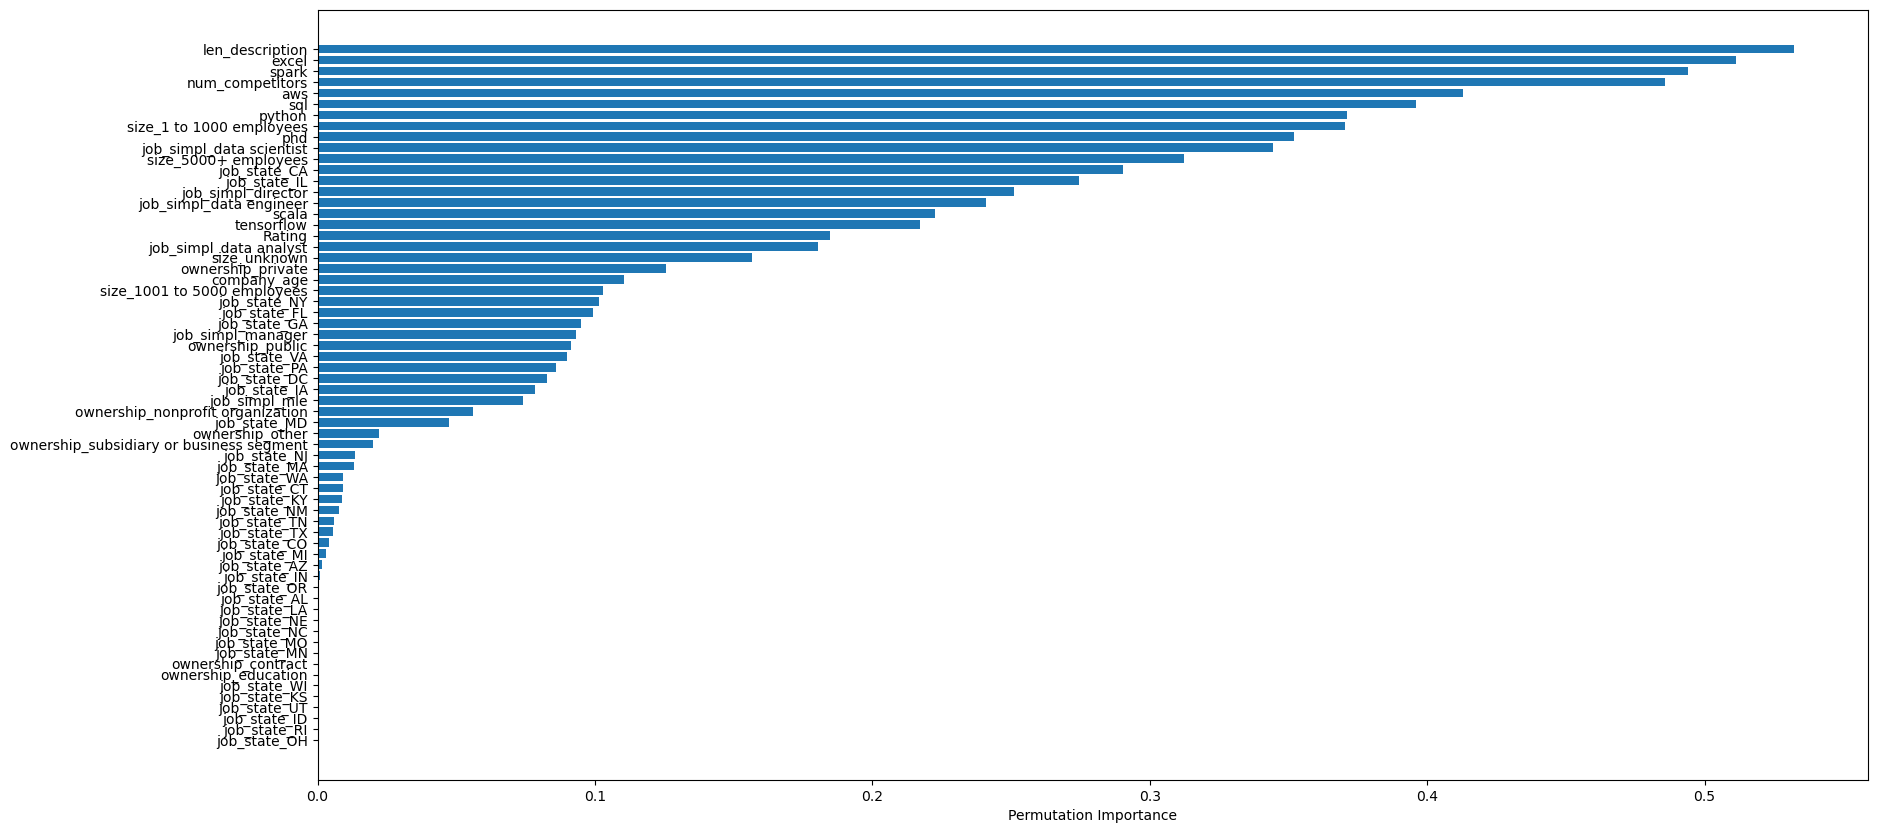

In [6]:
my_svr = svr_model.best_estimator_

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(my_svr, X_test, y_test)

feature_names = X_test.columns.to_list()
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(20,10))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Metrics for regression

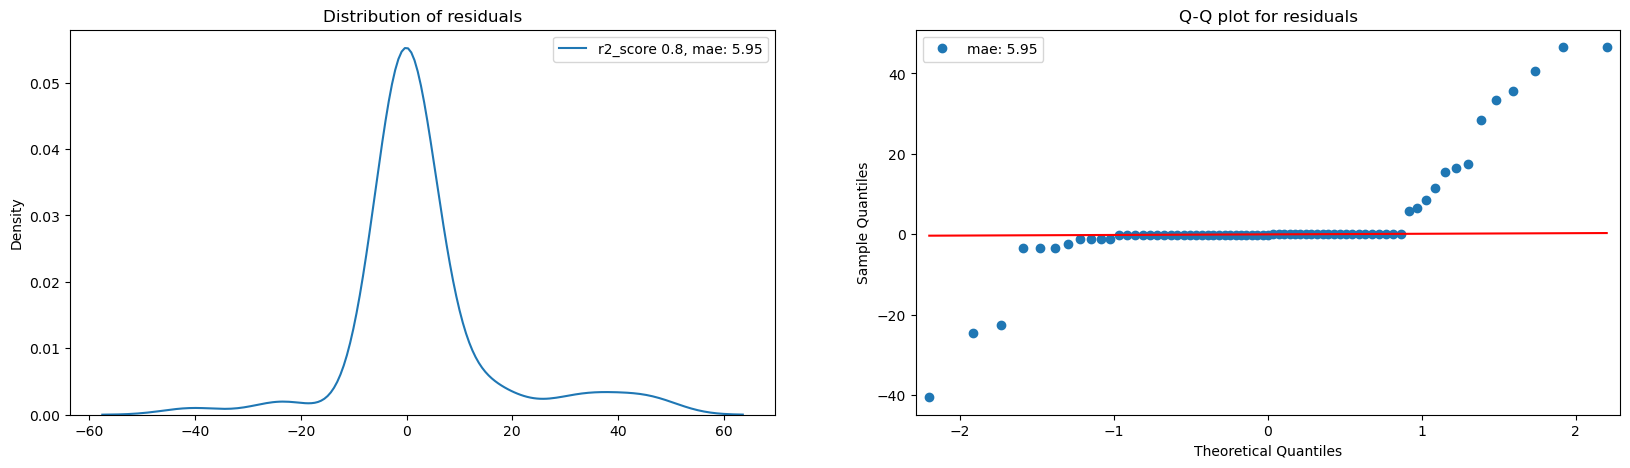

In [7]:
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm

def plot_residuals(y_true, y_predict):
    rows = 1
    cols = 2
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 5))
    residuals = y_predict - y_true
    ax[0].set_label(f"r2_score {round(r2_score(y_true, y_predict),2)}, mae: {round(mean_absolute_error(y_true, y_predict),2)}")
    ax[0].set_title('Distribution of residuals')
    sns.kdeplot(residuals, ax = ax[0], label = f"r2_score {round(r2_score(y_true, y_predict),2)}, mae: {round(mean_absolute_error(y_true, y_predict),2)}")
    ax[1].set_title('Q-Q plot for residuals')
    sm.qqplot(residuals,ax=ax[1], line = 'q', label = f"mae: {round(mean_absolute_error(y_true, y_predict),2)}")
    #ax[1].scatter(residuals, residuals, label= f"mae: {round(mean_absolute_error(y_true, y_predict),2)}")
    ax[0].legend()
    ax[1].legend()
    plt.show()

plot_residuals(y_test, svr_model.predict(X_test))

In [8]:
# Jarquebera test for normality in residuals, 
# ho = residuals are not assumed normal
# ha = residuals are asummed normal
# if p-value > 0.05 reject ho and accept ha
import statsmodels.stats.api as sms

jbera = sms.jarque_bera(svr_model.predict(X_test) - y_test)
print('JB:', round(jbera[0], 2), ', JB p-value:', jbera[1], '. So','reject ho. It means residuals are not assumed normal' if jbera[1] > 0.05 else 'not reject ha. It means residuals are assumed normal')

JB: 74.02 , JB p-value: 8.434939999606176e-17 . So not reject ha. It means residuals are assumed normal


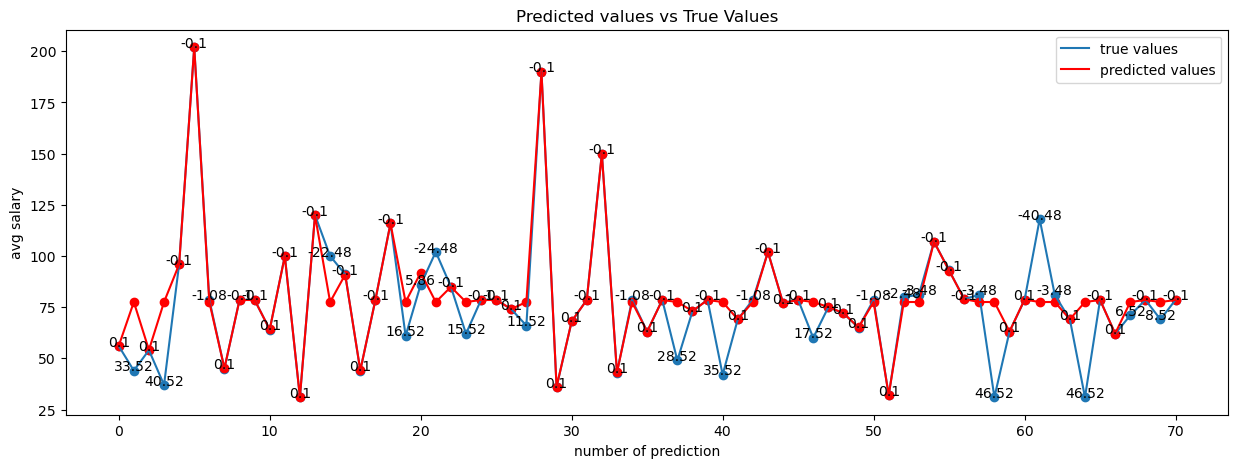

In [9]:
def addlabels(x,y, label):
    for i in range(len(x)):
        plt.text(i, y[i], round(label[i],2), ha = 'center')
        
plt.figure(figsize=(15,5))
plt.title('Predicted values vs True Values')
plt.xlabel('number of prediction')
plt.ylabel('avg salary')
addlabels(np.arange(len(y_test)),y_test,svr_model.predict(X_test) - y_test)
# plot true values
plt.plot(np.arange(len(y_test)),y_test, label = 'true values')
plt.scatter(np.arange(len(y_test)),y_test)
#plot predicted values
plt.scatter(np.arange(len((svr_model.predict(X_test)))),svr_model.predict(X_test), color = 'r')
plt.plot(np.arange(len((svr_model.predict(X_test)))),svr_model.predict(X_test), color = 'r', label='predicted values')
plt.legend()
plt.show()

#### XGBR model

Hyperparameter tuning

In [10]:
from xgboost import XGBRegressor

param_grid1 = {
    'n_estimators': [100],
    'learning_rate':[0.3],
    'max_depth': [50, 100, 500],
    'gamma': [0.0001,0.01],
    'booster': ['gbtree', 'dart']        
    }
xgbr_model = GridSearchCV(XGBRegressor(), param_grid= param_grid1, cv = 10, scoring = 'neg_mean_absolute_error', n_jobs=-1, verbose=1)
xgbr_model.fit(X_train, y_train)
pd.DataFrame(xgbr_model.cv_results_).sort_values(by= 'rank_test_score').head() # first 5 parameters combinations

Fitting 10 folds for each of 12 candidates, totalling 120 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.188780,0.096435,0.006575,0.001121,gbtree,0.0001,0.3,50,100,"{'booster': 'gbtree', 'gamma': 0.0001, 'learni...",-6.828172,-11.19406,-9.138303,-4.861055,-9.372539,-9.580196,-12.018265,-10.516197,-7.864125,-8.233510,-8.960642,2.01065,1
1,1.147710,0.109024,0.006438,0.001160,gbtree,0.0001,0.3,100,100,"{'booster': 'gbtree', 'gamma': 0.0001, 'learni...",-6.828172,-11.19406,-9.138303,-4.861055,-9.372539,-9.580196,-12.018265,-10.516197,-7.864125,-8.233510,-8.960642,2.01065,1
2,1.155690,0.153311,0.006130,0.000664,gbtree,0.0001,0.3,500,100,"{'booster': 'gbtree', 'gamma': 0.0001, 'learni...",-6.828172,-11.19406,-9.138303,-4.861055,-9.372539,-9.580196,-12.018265,-10.516197,-7.864125,-8.233510,-8.960642,2.01065,1
6,2.233079,0.074097,0.032137,0.002377,dart,0.0001,0.3,50,100,"{'booster': 'dart', 'gamma': 0.0001, 'learning...",-6.828172,-11.19406,-9.138304,-4.861055,-9.372540,-9.580197,-12.018264,-10.516197,-7.864125,-8.233511,-8.960643,2.01065,4
7,2.252794,0.096705,0.032688,0.004428,dart,0.0001,0.3,100,100,"{'booster': 'dart', 'gamma': 0.0001, 'learning...",-6.828172,-11.19406,-9.138304,-4.861055,-9.372540,-9.580197,-12.018264,-10.516197,-7.864125,-8.233511,-8.960643,2.01065,4


Metrics for regression

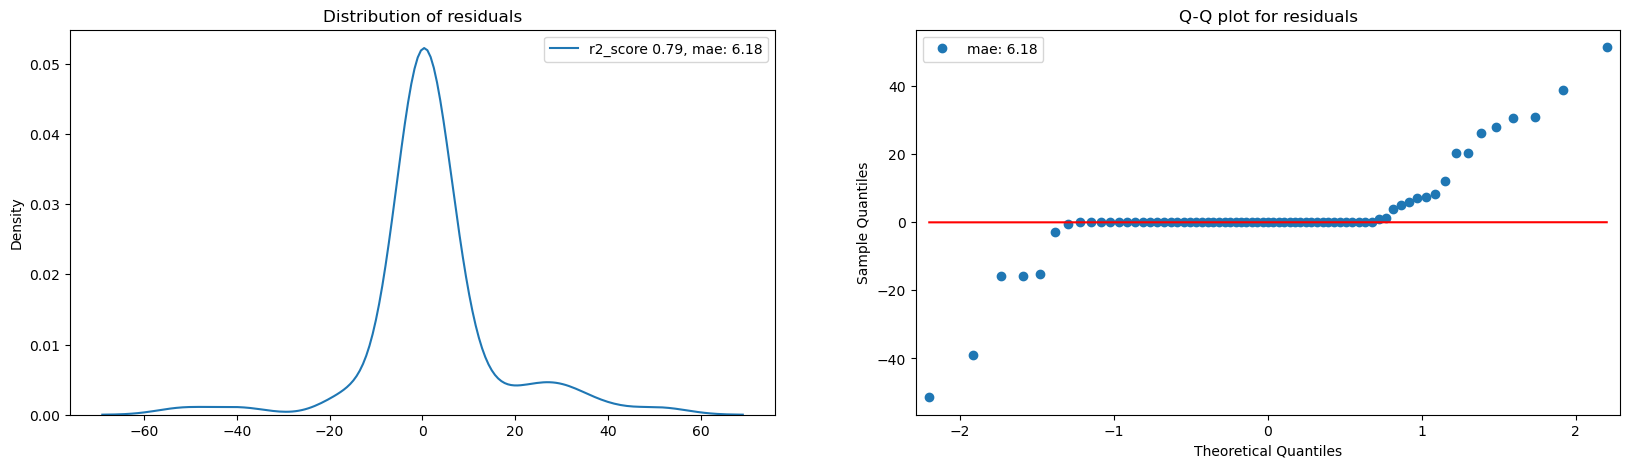

In [11]:
model2 = xgbr_model.best_estimator_
model2.fit(X_train, y_train)
plot_residuals(y_test, model2.predict(X_test))
